In [1]:
import pandas as pd
import numpy as np
import eurostat
from sklearn.preprocessing import LabelEncoder,StandardScaler, scale
from sklearn.model_selection import train_test_split  # Libraries for ML
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn import metrics,tree
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import validation_curve, KFold, cross_val_score, GridSearchCV
import warnings
warnings.filterwarnings('ignore') # We can suppress the warnings

In [2]:
# Modal split of inland passenger transport
# Unit of measure (% based on passenger-kilometres) : one passenger-km is one passenger transported over one kilometre
# https://ec.europa.eu/eurostat/databrowser/view/TRAN_HV_PSMOD__custom_2638259/bookmark/table?lang=en&bookmarkId=2d735f97-a7d6-4b24-bc27-a6c8e21db6a7
# Licence: https://ec.europa.eu/eurostat/about-us/policies/copyright
mldf = eurostat.get_data_df('TRAN_HV_PSMOD',True)                                                                 
mldf.head()
pd.set_option('display.float_format', lambda x: '%.2f' % x) 

mldf.head()

,freq,unit,vehicle,geo\TIME_PERIOD,1990_value,1990_flag,1991_value,1991_flag,1992_value,1992_flag,...,2017_value,2017_flag,2018_value,2018_flag,2019_value,2019_flag,2020_value,2020_flag,2021_value,2021_flag
0,A,PC,BUS_TOT,AT,11.00,,10.60,,10.50,,...,10.00,,9.50,be,9.70,e,9.30,e,9.00,e
1,A,PC,BUS_TOT,BE,10.60,e,10.70,e,10.70,e,...,10.20,e,10.30,e,10.40,e,8.20,e,8.20,e
2,A,PC,BUS_TOT,BG,NaN,:,NaN,:,NaN,:,...,13.10,e,12.00,e,13.00,e,8.60,e,8.00,e
3,A,PC,BUS_TOT,CH,3.70,,3.90,,4.00,,...,5.90,e,5.90,e,6.10,e,5.80,e,5.90,e
4,A,PC,BUS_TOT,CY,NaN,:,NaN,:,NaN,:,...,19.00,e,18.90,e,18.50,e,12.60,e,12.70,e


In [3]:
# Tyding up mldf

# Filter columns that do not contain '_flag'
mldf = mldf.filter(regex='^(?!.*_flag)')

# Renaming columns
mldf = mldf.rename(columns={'geo\\TIME_PERIOD': 'Country_code','vehicle':'Vehicle_type'})

# Dropping not needed rows:
# From column 'Vehicle_type' we don't need 'TRN_BUS_TOT_AVD'
# From column 'Country_code' we don't need 'EU27_2020' and 'EU28'
mldf = mldf[(mldf['Vehicle_type'] != 'TRN_BUS_TOT_AVD') & ~mldf['Country_code'].isin(['EU27_2020', 'EU28'])]

# Drop rows with null values
mldf = mldf.dropna()

# Dropping columns 'freq' and 'unit' we don't need them. Unit of measurement for this dataset is percentage
mldf = mldf.drop(['freq', 'unit'], axis=1).reset_index(drop=True)

# Trimming 'BUS_TOT' to have just 'BUS'
mldf['Vehicle_type'] = mldf['Vehicle_type'].str.replace('_TOT', '')

# Concatenate 'Country_code' and 'Vehicle_type'
mldf['Country_Vehicle'] = mldf['Country_code'] + '_' + mldf['Vehicle_type']

# Drop the original columns
mldf = mldf.drop(['Vehicle_type', 'Country_code'], axis=1)

mldf.head()

,1990_value,1991_value,1992_value,1993_value,1994_value,1995_value,1996_value,1997_value,1998_value,1999_value,...,2013_value,2014_value,2015_value,2016_value,2017_value,2018_value,2019_value,2020_value,2021_value,Country_Vehicle
0,11.00,10.60,10.50,10.70,10.60,10.90,10.70,10.90,10.90,10.70,...,9.90,9.90,9.90,9.90,10.00,9.50,9.70,9.30,9.00,AT_BUS
1,10.60,10.70,10.70,10.90,11.80,11.30,11.30,11.10,11.00,10.90,...,15.20,11.50,11.00,10.50,10.20,10.30,10.40,8.20,8.20,BE_BUS
2,3.70,3.90,4.00,3.90,4.00,3.80,3.60,3.60,5.30,5.20,...,5.70,5.80,5.90,5.90,5.90,5.90,6.10,5.80,5.90,CH_BUS
3,9.10,8.50,8.30,8.10,7.30,7.20,7.10,7.10,7.00,6.90,...,7.20,7.20,7.40,7.30,7.30,7.20,7.40,4.80,4.80,DE_BUS
4,11.30,11.10,15.20,15.30,15.50,16.60,17.40,16.90,14.10,13.90,...,9.80,9.80,9.80,9.80,10.00,9.60,9.20,6.80,7.10,DK_BUS


In [4]:
# We need to organise mldf, basically I want to have 'Year', 'Country_Vehicle' and 'value'
    
# Empty list to store results, initialising it
final_list = []

# Iterating over columns to extract the year from columns
for col in mldf.columns:
    if col.endswith('_value'):
        # Extracting each year from the columns
        year = col.split('_')[0]

        # Getting 'Vehicle_Country' for each row to get its corresponding values
        for index, row in mldf.iterrows():
            value = row[col]
            country_vehicle = row['Country_Vehicle']
            category = col.split('_')[1]  # Extract the category from the column name

            # Appending the final list as a dictionary
            final_list.append({
                'Year': year,
                'Country_Vehicle': country_vehicle,
                'Category': category,
                'Value': value
            })
            
# Converting 'final_list' to a DataFrame
Y_CV_V_df = pd.DataFrame(final_list)

# Pivot the DataFrame
Y_CV_V_df = Y_CV_V_df.pivot_table(index=['Year', 'Country_Vehicle'], columns='Category', values='Value').reset_index()
Y_CV_V_df = Y_CV_V_df.rename_axis(None, axis=1) # Index with no name as it should be
   
mldf = Y_CV_V_df.copy() #Reusing variable mldf

mldf.head()

,Year,Country_Vehicle,value
0,1990,AT_BUS,11.00
1,1990,AT_CAR,77.10
2,1990,AT_TRN,11.90
3,1990,BE_BUS,10.60
4,1990,BE_CAR,83.30


In [5]:
mldf.shape

(1728, 3)

In [6]:
# Dataset will be used in the second part of this section
mldf1a = mldf.copy() 

In [7]:
# Creating mdf1 for stats

mldf1 = mldf.copy()

In [8]:
# Pivot the DataFrame
mldf1 = mldf1.pivot(index='Year', columns='Country_Vehicle', values='value').reset_index()
mldf1 = mldf1.rename_axis(None, axis=1)
mldf1.head()

,Year,AT_BUS,AT_CAR,AT_TRN,BE_BUS,BE_CAR,BE_TRN,CH_BUS,CH_CAR,CH_TRN,...,PL_TRN,PT_BUS,PT_CAR,PT_TRN,SE_BUS,SE_CAR,SE_TRN,SI_BUS,SI_CAR,SI_TRN
0,1990,11.00,77.10,11.90,10.60,83.30,6.10,3.70,82.10,14.20,...,30.50,18.40,71.50,10.10,9.50,84.10,6.50,30.60,62.70,6.70
1,1991,10.60,77.00,12.40,10.70,83.30,6.10,3.90,81.10,15.00,...,24.60,18.60,71.40,9.90,9.50,84.70,5.90,29.30,66.40,4.30
2,1992,10.50,77.00,12.50,10.70,83.30,6.00,4.00,81.40,14.60,...,20.30,22.70,68.20,9.00,9.40,84.80,5.80,23.00,73.90,3.00
3,1993,10.70,77.20,12.10,10.90,83.30,5.90,3.90,80.90,15.20,...,17.70,19.30,72.20,8.50,9.30,84.40,6.30,21.10,75.80,3.10
4,1994,10.60,77.80,11.60,11.80,82.60,5.60,4.00,79.80,16.20,...,15.60,17.90,74.30,7.80,9.30,84.40,6.30,20.40,76.60,3.00


In [9]:
# sdf1.describe(include='all').T # Transposing columns to see each Country_Vehicle
# passing the stats into 'mldf1' dataframe
mldf1 = (mldf1.describe(include='all').T).reset_index().rename_axis(None, axis=1).copy()

# Dropping first row we don't need Years we already now that year range goes from 1990 to 2021
mldf1 = mldf1.drop(0)

# Renaming columns
mldf1 = mldf1.rename(columns={'index': 'Country_Vehicle'}).drop(['unique', 'top','freq','count','std','25%','50%','75%','max','min'], axis=1).sort_values(by='mean', ascending=False).reset_index(drop=True)

mldf1

,Country_Vehicle,mean
0,NL_CAR,86.12
1,FR_CAR,85.38
2,DE_CAR,85.35
3,LU_CAR,84.58
4,PT_CAR,84.52
5,FI_CAR,83.88
6,SE_CAR,83.50
7,IE_CAR,82.85
8,SI_CAR,82.72
9,IT_CAR,82.16


In [10]:
def highlight_countries(row):
    styles = [''] * len(row)
    
    # Highlight 'IE' in yellow
    if row['Country_Vehicle'].startswith('IE'):
        styles = ['background-color: yellow'] * len(row)
    
    # Highlight 'HU' in lightgreen
    elif row['Country_Vehicle'].startswith('HU'):
        styles = ['background-color: lightgreen'] * len(row)
    
    return styles

# Apply the highlighting function to the DataFrame
mldf1 = mldf1.style.apply(highlight_countries, axis=1)

mldf1

,Country_Vehicle,mean
0,NL_CAR,86.121875
1,FR_CAR,85.378125
2,DE_CAR,85.346875
3,LU_CAR,84.575000
4,PT_CAR,84.515625
5,FI_CAR,83.878125
6,SE_CAR,83.496875
7,IE_CAR,82.850000
8,SI_CAR,82.718750
9,IT_CAR,82.156250


In [11]:
# Modify the code to filter based on substrings
mldf = mldf[mldf['Country_Vehicle'].str.contains('IE|HU', case=False, na=False)]
mldf.reset_index(drop=True, inplace=True)

# Outlier Analysis:

In [12]:
# # Box plot to identify outliers
# sns.boxplot(x='Luas_Line', y='VALUE', data=df)
# plt.show()


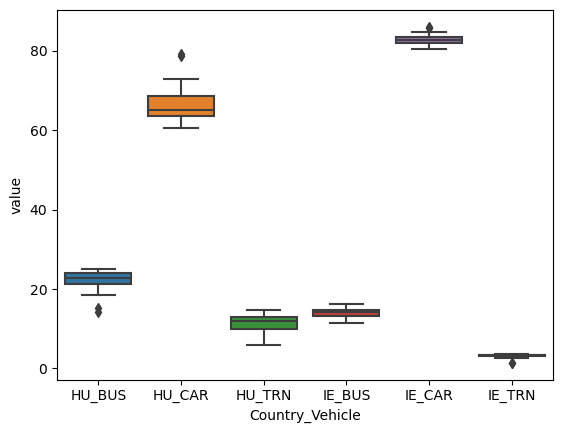

In [13]:
# Box plot to identify outliers
sns.boxplot(x='Country_Vehicle', y='value', data=mldf)

plt.show()


No need to remove outliers

In [14]:
mldf

,Year,Country_Vehicle,value
0,1990,HU_BUS,24.80
1,1990,HU_CAR,60.50
2,1990,HU_TRN,14.70
3,1990,IE_BUS,11.50
4,1990,IE_CAR,84.90
...,...,...,...
187,2021,HU_CAR,79.30
188,2021,HU_TRN,6.40
189,2021,IE_BUS,13.00
190,2021,IE_CAR,85.70


In [15]:
# Move the 'Year' column to the second position
mldf.insert(1, 'Year', mldf.pop('Year'))

In [16]:
# Counting the values that each year has:
year_counts = mldf['Year'].value_counts().sort_index()
year_counts

Year
1990    6
1991    6
1992    6
1993    6
1994    6
1995    6
1996    6
1997    6
1998    6
1999    6
2000    6
2001    6
2002    6
2003    6
2004    6
2005    6
2006    6
2007    6
2008    6
2009    6
2010    6
2011    6
2012    6
2013    6
2014    6
2015    6
2016    6
2017    6
2018    6
2019    6
2020    6
2021    6
Name: count, dtype: int64

In [17]:
mldf

,Country_Vehicle,Year,value
0,HU_BUS,1990,24.80
1,HU_CAR,1990,60.50
2,HU_TRN,1990,14.70
3,IE_BUS,1990,11.50
4,IE_CAR,1990,84.90
...,...,...,...
187,HU_CAR,2021,79.30
188,HU_TRN,2021,6.40
189,IE_BUS,2021,13.00
190,IE_CAR,2021,85.70


In [18]:
# Creating a LabelEncoder instance
le = LabelEncoder()

# Encoding the 'Sex' column
mldf['Country_Vehicle'] = le.fit_transform(mldf['Country_Vehicle'])
pd.set_option('display.float_format', lambda x: '%.2f' % x) 
mldf

,Country_Vehicle,Year,value
0,0,1990,24.80
1,1,1990,60.50
2,2,1990,14.70
3,3,1990,11.50
4,4,1990,84.90
...,...,...,...
187,1,2021,79.30
188,2,2021,6.40
189,3,2021,13.00
190,4,2021,85.70


Encoding target variable *"Luas_Line"*:<br>
*"Red Line"* = 0 <br>
*"Green Line"* = 1<br>
Defining X and y variables:

In [19]:
X = mldf.iloc[:, [1,2]].values # Dependent variables
y = mldf.iloc[:, 0].values # Target variable

In [20]:
X

array([['1990', 24.8],
       ['1990', 60.5],
       ['1990', 14.7],
       ['1990', 11.5],
       ['1990', 84.9],
       ['1990', 3.6],
       ['1991', 23.4],
       ['1991', 63.2],
       ['1991', 13.3],
       ['1991', 11.9],
       ['1991', 84.3],
       ['1991', 3.7],
       ['1992', 22.9],
       ['1992', 63.9],
       ['1992', 13.2],
       ['1992', 12.3],
       ['1992', 84.2],
       ['1992', 3.5],
       ['1993', 23.2],
       ['1993', 64.5],
       ['1993', 12.4],
       ['1993', 12.6],
       ['1993', 83.8],
       ['1993', 3.6],
       ['1994', 23.5],
       ['1994', 64.3],
       ['1994', 12.2],
       ['1994', 13.6],
       ['1994', 83.0],
       ['1994', 3.4],
       ['1995', 23.6],
       ['1995', 64.4],
       ['1995', 12.0],
       ['1995', 13.6],
       ['1995', 83.0],
       ['1995', 3.4],
       ['1996', 25.0],
       ['1996', 63.2],
       ['1996', 11.8],
       ['1996', 13.5],
       ['1996', 83.3],
       ['1996', 3.3],
       ['1997', 24.0],
       ['1997', 64

In [21]:
y

array([0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3,
       4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1,
       2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5,
       0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3,
       4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1,
       2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5,
       0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3,
       4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1,
       2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5])

## Splitting the dataset into the Training set and Test set

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

## Feature Scaling

In [23]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# DecisionTreeClassifier
## Training the Decision Tree Classification model on the Training set

In [24]:
classifier = DecisionTreeClassifier(max_depth = 4, random_state = 0)
classifier.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=0)

## Predicting the Test and set results

In [25]:
y_pred = classifier.predict(X_test)

## Making the Confusion Matrix

              precision    recall  f1-score   support

           0       1.00      0.92      0.96        12
           1       1.00      1.00      1.00        12
           2       0.92      0.92      0.92        12
           3       0.71      0.83      0.77         6
           4       1.00      1.00      1.00         7
           5       1.00      1.00      1.00         9

    accuracy                           0.95        58
   macro avg       0.94      0.94      0.94        58
weighted avg       0.95      0.95      0.95        58

Classifier Accuracy: 94.83


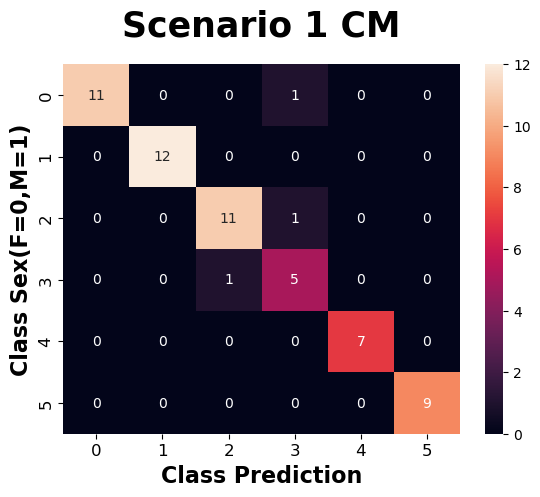

In [26]:
# Calculating confusion matrix

cm = confusion_matrix(y_test, y_pred)

# Call a method heatmap() to plot confusion matrix
sns.heatmap(cm, annot = True,fmt='d')
plt.title('Scenario 1 CM',loc="center", pad=20, fontsize=25, fontweight="bold")
plt.xlabel('Class Prediction',fontsize=16, fontweight='bold')
plt.ylabel('Class Sex(F=0,M=1)',fontsize=16, fontweight='bold')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# We don't want scientific notation
np.set_printoptions(suppress=True)

# print the classification_report based on y_test and y_predict
print(classification_report(y_test, y_pred))
# Which is the accuracy for the classifier???
print("Classifier Accuracy:",round(metrics.accuracy_score(y_test, y_pred),4)*100)

tree=metrics.accuracy_score(y_test, y_pred)*100

In [27]:
# instantiate the classifier 
rfc = RandomForestClassifier(n_estimators=10,random_state=0) # Setting 10 trees

# fit the model
rfc.fit(X_train, y_train)

# Predict the Test set results
y_pred = rfc.predict(X_test)

print('Model accuracy score with 10 decision-trees : {0:0.2f}'. format(accuracy_score(y_test, y_pred)*100))
randomforest = accuracy_score(y_test, y_pred)*100

Model accuracy score with 10 decision-trees : 93.10


In [28]:
# Check the number of decision trees in the Random Forest
num_decision_trees = rfc.n_estimators

# Print the number of decision trees
print(f'Number of decision trees in the Random Forest: {num_decision_trees}')


Number of decision trees in the Random Forest: 10


## Creating a K-Nearest Neighbor Classifier

In [29]:
neighbors = np.arange(1, 20)                  # number of neighbors
train_accuracy = np.zeros(len(neighbors))    # Declare and initialise the matrix
test_accuracy = np.zeros(len(neighbors))     # Declare and initialise the matrix

In [30]:
for i,k in enumerate(neighbors):                          # for loop that checks the model for neighbor values 1, 2, 3, ..., 9
    knn = KNeighborsClassifier(n_neighbors = k)           # Initialise an object knn using KNeighborsClassifier method

    #Fit the model
    knn.fit(X_train, y_train)                      # Call fit method to implement the ML KNeighborsClassifier model

    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)      # Save the score value in the train_accuracy array

    #Compute accuracy on the test set
    test_accuracy[i] = knn.score(X_test, y_test)      # Save the score value in the train_accuracy array

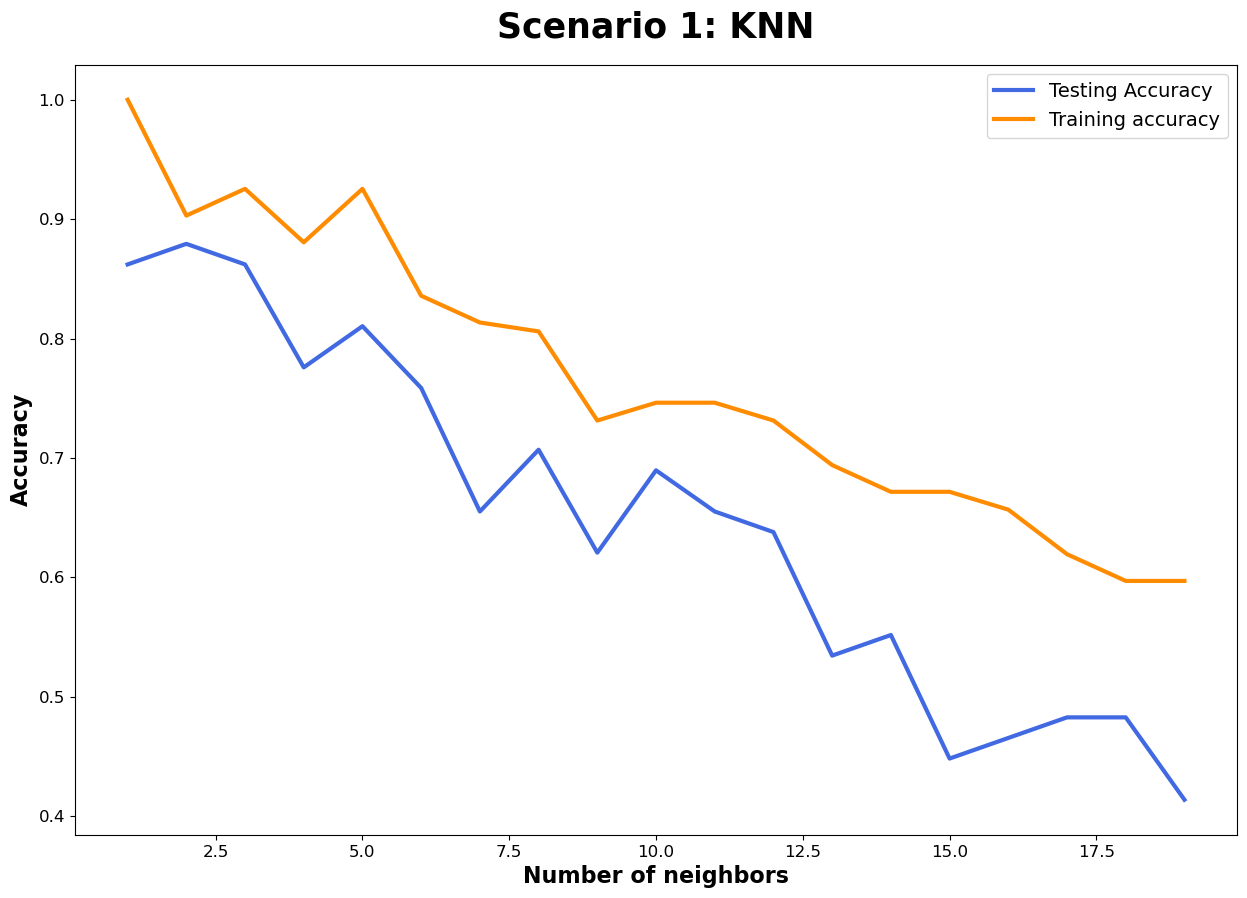

In [31]:
plt.figure(figsize=(15, 10))
plt.title('Scenario 1: KNN',loc="center", pad=20, fontsize=25, fontweight="bold")
plt.plot(neighbors, test_accuracy, label='Testing Accuracy', linewidth=3, color='royalblue')
plt.plot(neighbors, train_accuracy, label='Training accuracy', linewidth=3, color='darkorange')

plt.xlabel('Number of neighbors',fontsize=16, fontweight='bold')
plt.ylabel('Accuracy',fontsize=16, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend( loc='best', fontsize=14)
plt.show()

In [32]:
# Declare and initialise an object 'KNeighborsClassifier' with 3 neighbors
knn = KNeighborsClassifier(n_neighbors = 3)

# Fit the model
knn.fit(X_train, y_train)   

# Compute accuracy on the training set
train_accuracy = knn.score(X_train, y_train)   

# Compute accuracy on the test set
test_accuracy = knn.score(X_test, y_test)  

In [33]:
# Display the test accuracy

print('Test accuracy = ', round(test_accuracy*100,2))
KNN=test_accuracy*100

Test accuracy =  86.21


# Parameter tunning GridSearch

In [34]:
# scaling the features

X_scaled = scale(X)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = 42)

## Model Building

In [35]:
# using rbf kernel, C=1, default value of gamma

model = SVC(C = 1, kernel='rbf')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


              precision    recall  f1-score   support

           0       0.73      1.00      0.84         8
           1       1.00      1.00      1.00         5
           2       0.22      0.50      0.31         4
           3       0.00      0.00      0.00        10
           4       1.00      1.00      1.00         8
           5       0.67      1.00      0.80         4

    accuracy                           0.69        39
   macro avg       0.60      0.75      0.66        39
weighted avg       0.57      0.69      0.62        39

accuracy 0.6923076923076923
precision 0.5736855736855737
recall 0.6923076923076923


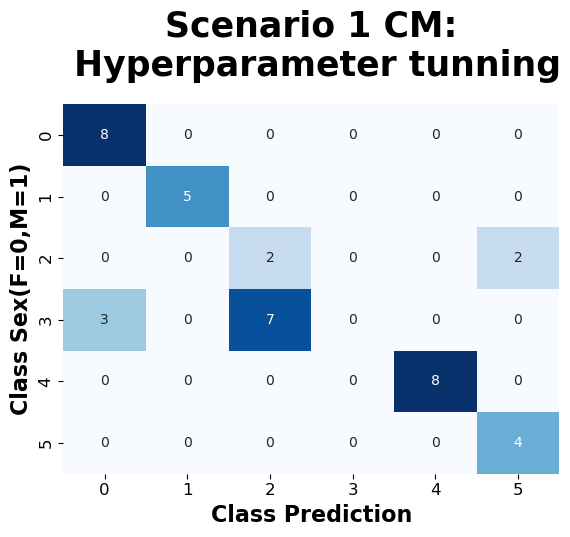

In [36]:
# confusion matrix
confusion_matrix(y_true=y_test, y_pred=y_pred)

# Generate the confusion matrix
confusion_matrix = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred)

# Create a heatmap of the confusion matrix

sns.heatmap(confusion_matrix, annot = True, fmt = "d", cmap = "Blues", cbar = False, )
plt.title('Scenario 1 CM:\n Hyperparameter tunning',loc="center", pad=20, fontsize=25, fontweight="bold")
plt.xlabel('Class Prediction',fontsize=16, fontweight='bold')
plt.ylabel('Class Sex(F=0,M=1)',fontsize=16, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Printing classification report
print(classification_report(y_test, y_pred))

# accuracy
print("accuracy", metrics.accuracy_score(y_test, y_pred))

svc = metrics.accuracy_score(y_test, y_pred)*100

# precision
print("precision", metrics.precision_score(y_test, y_pred, average='weighted'))

# recall/sensitivity
print("recall", metrics.recall_score(y_test, y_pred, average='weighted'))

## Grid Search to Find Optimal Hyperparameters

In [37]:
# creating a KFold object with 5 splits 
folds = KFold(n_splits = 5, shuffle = True, random_state = 0)

# specify range of hyperparameters
# Set the parameters by cross-validation
hyper_params = [ {'gamma': [0.01, 0.001, 0.0001],
                     'C': [1, 10, 100, 1000]}]#,
                


# specify model
model = SVC(kernel = "rbf")

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = model, 
                        param_grid = hyper_params, 
                        scoring = 'accuracy', 
                        cv = folds, 
                        verbose = 4, # Changing verbose from 1 to 4, to display records :)
                        return_train_score = True)      

# fit the model
model_cv.fit(X_train, y_train)     

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END C=1, gamma=0.01;, score=(train=0.533, test=0.387) total time=   0.0s
[CV 2/5] END C=1, gamma=0.01;, score=(train=0.377, test=0.290) total time=   0.0s
[CV 3/5] END C=1, gamma=0.01;, score=(train=0.361, test=0.355) total time=   0.0s
[CV 4/5] END C=1, gamma=0.01;, score=(train=0.382, test=0.400) total time=   0.0s
[CV 5/5] END C=1, gamma=0.01;, score=(train=0.472, test=0.267) total time=   0.0s
[CV 1/5] END C=1, gamma=0.001;, score=(train=0.197, test=0.129) total time=   0.0s
[CV 2/5] END C=1, gamma=0.001;, score=(train=0.205, test=0.097) total time=   0.0s
[CV 3/5] END C=1, gamma=0.001;, score=(train=0.189, test=0.161) total time=   0.0s
[CV 4/5] END C=1, gamma=0.001;, score=(train=0.220, test=0.200) total time=   0.0s
[CV 5/5] END C=1, gamma=0.001;, score=(train=0.195, test=0.100) total time=   0.0s
[CV 1/5] END C=1, gamma=0.0001;, score=(train=0.197, test=0.129) total time=   0.0s
[CV 2/5] END C=1, gamma=0.0001

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=SVC(),
             param_grid=[{'C': [1, 10, 100, 1000],
                          'gamma': [0.01, 0.001, 0.0001]}],
             return_train_score=True, scoring='accuracy', verbose=4)

In [38]:
## cv results
cv_results = pd.DataFrame(model_cv.cv_results_)

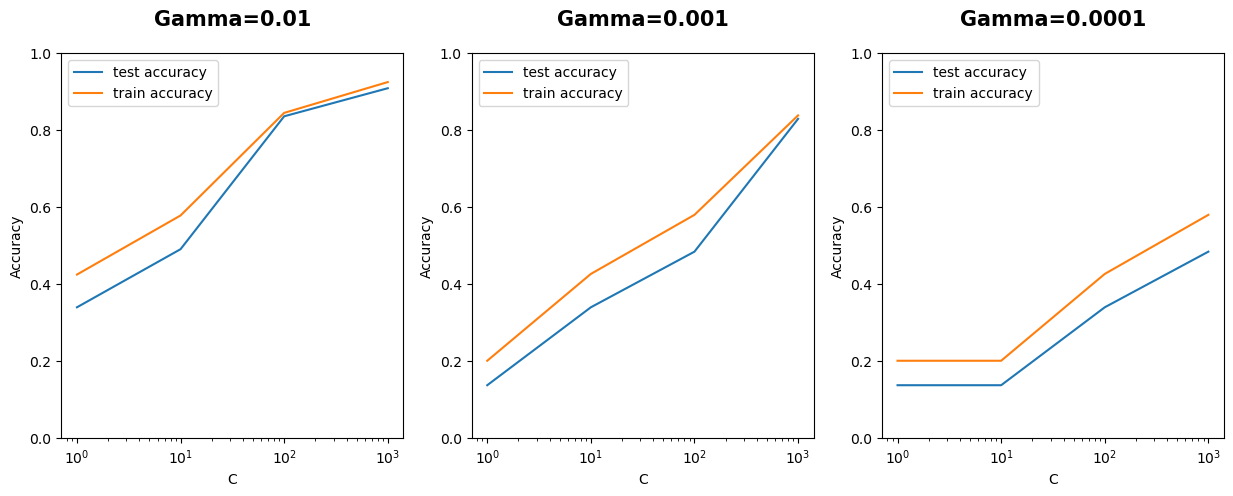

In [39]:
# converting C to numeric type for plotting on x-axis
cv_results['param_C'] = cv_results['param_C'].astype('int')

# # plotting
plt.figure(figsize=(15,5))

# subplot 1/3
plt.subplot(131)
gamma_01 = cv_results[cv_results['param_gamma']==0.01]

plt.plot(gamma_01["param_C"], gamma_01["mean_test_score"])
plt.plot(gamma_01["param_C"], gamma_01["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.01",fontweight="bold",loc="center", pad=20, fontsize=15)
plt.ylim([0, 1])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

# subplot 2/3
plt.subplot(132)
gamma_001 = cv_results[cv_results['param_gamma']==0.001]

plt.plot(gamma_001["param_C"], gamma_001["mean_test_score"])
plt.plot(gamma_001["param_C"], gamma_001["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.001",fontweight="bold",loc="center", pad=20, fontsize=15)
plt.ylim([0, 1])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')


# subplot 3/3
plt.subplot(133)
gamma_0001 = cv_results[cv_results['param_gamma']==0.0001]

plt.plot(gamma_0001["param_C"], gamma_0001["mean_test_score"])
plt.plot(gamma_0001["param_C"], gamma_0001["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.0001",fontweight="bold",loc="center", pad=20, fontsize=15)
plt.ylim([0, 1])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

In [40]:
# printing the optimal accuracy score and hyperparameters
best_score = model_cv.best_score_
best_hyperparams = model_cv.best_params_
print('Tree:',tree)
print('RF:',randomforest)
print('KNN:',KNN)
print('SVC:',svc)
print("The best test score is {0} corresponding to hyperparameters {1}".format(best_score, best_hyperparams))

Tree: 94.82758620689656
RF: 93.10344827586206
KNN: 86.20689655172413
SVC: 69.23076923076923
The best test score is 0.9088172043010753 corresponding to hyperparameters {'C': 1000, 'gamma': 0.01}


Gamma = 0.01 overfitted model <br>

Gamma=0.001 less overfitted model <br>

Gamma=0.0001 fitten model <br>

This plot reveals some interesting insights:
- **High values of gamma** lead to **overfitting** (especially at high values of C); note that the training accuracy at gamma=0.01 and C=1000 reaches almost 99% 
- The **training score increases with higher gamma**, though the **test scores are comparable** (at sufficiently high cost, i.e. C > 10)
- The least amount of overfitting (i.e. difference between train and test accuracy) occurs at low gamma, i.e. a quite *simple non-linear model*

# Conclusion:
We can see that Gamma = 0.0001 Graph is at around 60% accuracy whereas Gamma Graps at 0.01 and 0.001 are hiting 80% accuracy and above.

# Increasing dataset to get higher accuracy at Gamma = 0.0001.

In [41]:
# Modify the code to filter based on substrings
mldf1a = mldf1a[mldf1a['Country_Vehicle'].str.contains('IE|HU', case=False, na=False)]
mldf1a.reset_index(drop=True, inplace=True)

In [42]:
def break_into_trimesters(row):
    # Define the fixed weights for trimesters
    weights = [0.23, 0.27,0.24 , 0.26] # weights = 1

    # Create a dataframe to store the result
    result_df = pd.DataFrame({'Trimester': range(1, 5),
                              'Weight': weights})

    # Calculate the value for each trimester
    result_df['value'] = row['value'] * result_df['Weight']

    # Merge the result with the original row
    result_df['Country_Vehicle'] = row['Country_Vehicle']
    result_df['Year'] = row['Year']

    return result_df
# Apply the function to each row of the dataframe
mldf1a = pd.concat(mldf1a.apply(break_into_trimesters, axis=1).to_list(), ignore_index=True)

# Display the resulting dataframe
mldf1a

,Trimester,Weight,value,Country_Vehicle,Year
0,1,0.23,5.70,HU_BUS,1990
1,2,0.27,6.70,HU_BUS,1990
2,3,0.24,5.95,HU_BUS,1990
3,4,0.26,6.45,HU_BUS,1990
4,1,0.23,13.92,HU_CAR,1990
...,...,...,...,...,...
763,4,0.26,22.28,IE_CAR,2021
764,1,0.23,0.32,IE_TRN,2021
765,2,0.27,0.38,IE_TRN,2021
766,3,0.24,0.34,IE_TRN,2021


In [43]:
# Dropping the 'STATISTIC Label' column it's irrelevant for the analysis
df_col_drop = ['Trimester','Weight']
mldf1a.drop(df_col_drop ,axis=1, inplace=True) 

In [44]:
# Move the 'Year' column to the second position
mldf1a.insert(2, 'value', mldf1a.pop('value'))

In [45]:
mldf1a.head()

,Country_Vehicle,Year,value
0,HU_BUS,1990,5.70
1,HU_BUS,1990,6.70
2,HU_BUS,1990,5.95
3,HU_BUS,1990,6.45
4,HU_CAR,1990,13.92


In [46]:
# Creating a LabelEncoder instance
le = LabelEncoder()

# Encoding the 'Sex' column
mldf1a['Country_Vehicle'] = le.fit_transform(mldf1a['Country_Vehicle'])
pd.set_option('display.float_format', lambda x: '%.2f' % x) 
mldf1a

,Country_Vehicle,Year,value
0,0,1990,5.70
1,0,1990,6.70
2,0,1990,5.95
3,0,1990,6.45
4,1,1990,13.92
...,...,...,...
763,4,2021,22.28
764,5,2021,0.32
765,5,2021,0.38
766,5,2021,0.34


In [47]:
X = mldf1a.iloc[:, [1,2]].values # Dependent variables
y = mldf1a.iloc[:, 0].values # Target variable

In [48]:
X

array([['1990', 5.704000000000001],
       ['1990', 6.696000000000001],
       ['1990', 5.952],
       ...,
       ['2021', 0.378],
       ['2021', 0.33599999999999997],
       ['2021', 0.364]], dtype=object)

In [49]:
y

array([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5,
       5, 5, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4,
       5, 5, 5, 5, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4,
       4, 4, 5, 5, 5, 5, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3,
       4, 4, 4, 4, 5, 5, 5, 5, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3,
       3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2,
       3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2,
       2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 0, 0, 0, 0, 1, 1, 1, 1,
       2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 0, 0, 0, 0, 1, 1,
       1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 0, 0, 0, 0,
       1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 0, 0,
       0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5,
       0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5,
       5, 5, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3,

## Splitting the dataset into the Training set and Test set

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

## Feature Scaling

In [51]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# DecisionTreeClassifier
## Training the Decision Tree Classification model on the Training set

In [52]:
classifier = DecisionTreeClassifier(max_depth = 4, random_state = 0)
classifier.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=0)

## Predicting the Test and set results

In [53]:
y_pred = classifier.predict(X_test)

## Making the Confusion Matrix

              precision    recall  f1-score   support

           0       0.91      0.96      0.93        45
           1       0.91      0.95      0.93        42
           2       0.68      0.79      0.73        29
           3       0.76      0.63      0.69        41
           4       0.94      0.88      0.91        34
           5       1.00      1.00      1.00        40

    accuracy                           0.87       231
   macro avg       0.87      0.87      0.87       231
weighted avg       0.88      0.87      0.87       231

Classifier Accuracy: 87.45


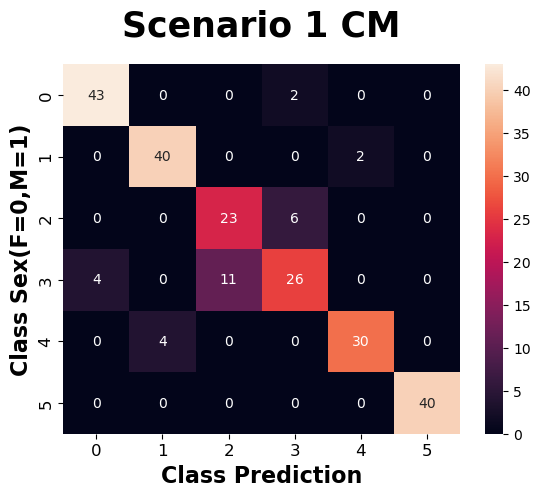

In [54]:
from sklearn.metrics import confusion_matrix # We need to reimport this libary, otherwise breaks
# Calculating confusion matrix1
cm = confusion_matrix(y_test, y_pred)

# Call a method heatmap() to plot confusion matrix
sns.heatmap(cm, annot = True,fmt='d')
plt.title('Scenario 1 CM',loc="center", pad=20, fontsize=25, fontweight="bold")
plt.xlabel('Class Prediction',fontsize=16, fontweight='bold')
plt.ylabel('Class Sex(F=0,M=1)',fontsize=16, fontweight='bold')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# We don't want scientific notation
np.set_printoptions(suppress=True)

# print the classification_report based on y_test and y_predict
print(classification_report(y_test, y_pred))
# Which is the accuracy for the classifier???
print("Classifier Accuracy:",round(metrics.accuracy_score(y_test, y_pred),4)*100)

tree=metrics.accuracy_score(y_test, y_pred)*100

In [55]:
# instantiate the classifier 
rfc = RandomForestClassifier(random_state=0,verbose=0)

# fit the model
rfc.fit(X_train, y_train)

# Predict the Test set results
y_pred = rfc.predict(X_test)

print('Model accuracy score with 10 decision-trees : {0:0.2f}'. format(accuracy_score(y_test, y_pred)*100))
randomforest = accuracy_score(y_test, y_pred)*100

Model accuracy score with 10 decision-trees : 91.77


## Creating a K-Nearest Neighbor Classifier

In [56]:
neighbors = np.arange(1, 20)                  # number of neighbors
train_accuracy = np.zeros(len(neighbors))    # Declare and initialise the matrix
test_accuracy = np.zeros(len(neighbors))     # Declare and initialise the matrix

In [57]:
for i,k in enumerate(neighbors):                          # for loop that checks the model for neighbor values 1, 2, 3, ..., 9
    knn = KNeighborsClassifier(n_neighbors = k)           # Initialise an object knn using KNeighborsClassifier method

    #Fit the model
    knn.fit(X_train, y_train)                      # Call fit method to implement the ML KNeighborsClassifier model

    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)      # Save the score value in the train_accuracy array

    #Compute accuracy on the test set
    test_accuracy[i] = knn.score(X_test, y_test)      # Save the score value in the train_accuracy array

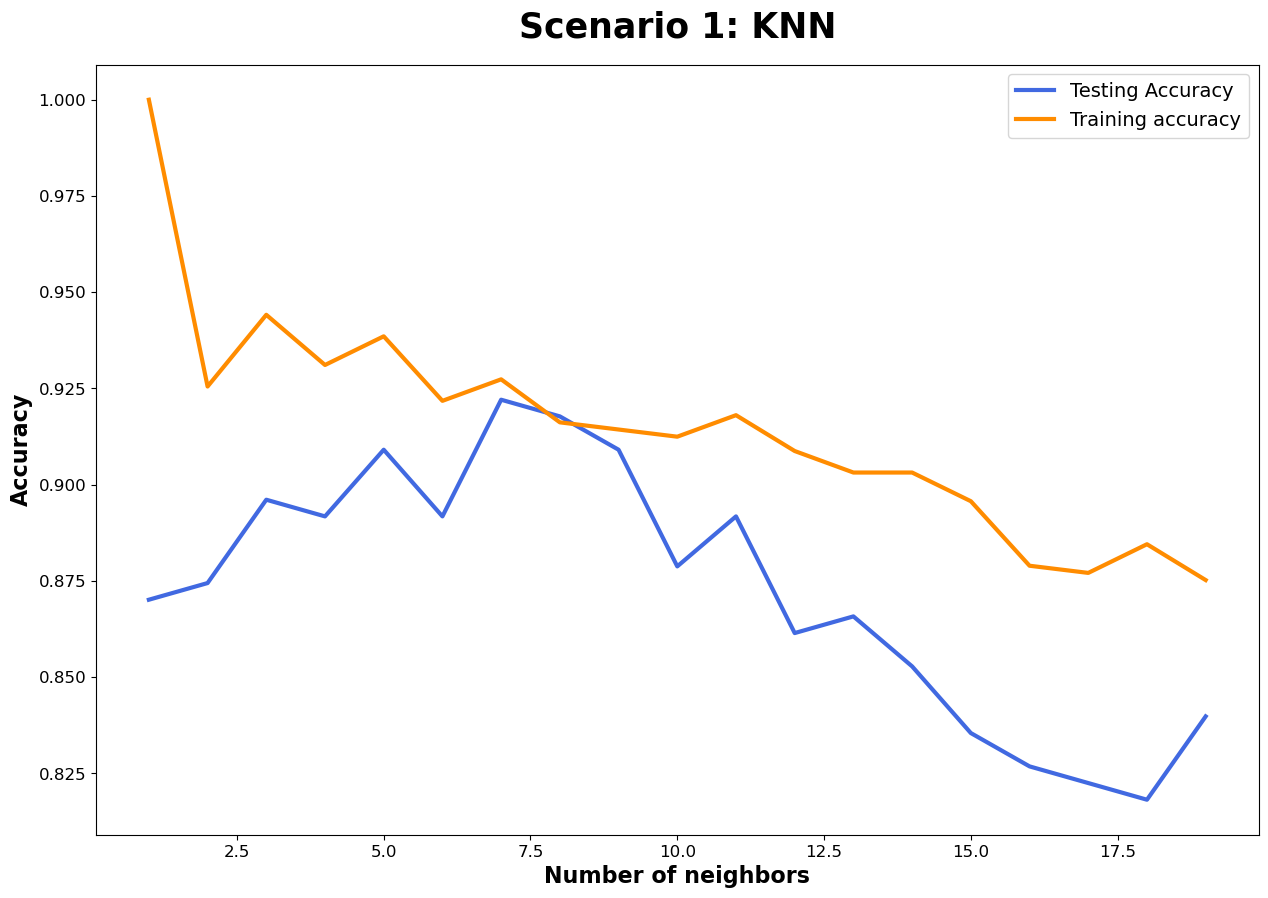

In [58]:
plt.figure(figsize=(15, 10))
plt.title('Scenario 1: KNN',loc="center", pad=20, fontsize=25, fontweight="bold")
plt.plot(neighbors, test_accuracy, label='Testing Accuracy', linewidth=3, color='royalblue')
plt.plot(neighbors, train_accuracy, label='Training accuracy', linewidth=3, color='darkorange')

plt.xlabel('Number of neighbors',fontsize=16, fontweight='bold')
plt.ylabel('Accuracy',fontsize=16, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend( loc='best', fontsize=14)
plt.show()

In [59]:
# Declare and initialise an object 'KNeighborsClassifier' with 3 neighbors
knn = KNeighborsClassifier(n_neighbors = 2)

# Fit the model
knn.fit(X_train, y_train)   

# Compute accuracy on the training set
train_accuracy = knn.score(X_train, y_train)   

# Compute accuracy on the test set
test_accuracy = knn.score(X_test, y_test)  

In [60]:
# Display the test accuracy

print('Test accuracy = ', round(test_accuracy*100,2))
KNN=test_accuracy*100

Test accuracy =  87.45


# Parameter tunning GridSearch

In [61]:
# scaling the features

X_scaled = scale(X)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = 42)

## Model Building

In [62]:
# using rbf kernel, C=1, default value of gamma

model = SVC(C = 1, kernel='rbf')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


              precision    recall  f1-score   support

           0       1.00      0.97      0.98        30
           1       0.94      0.97      0.95        30
           2       0.58      0.86      0.69        21
           3       0.91      0.43      0.59        23
           4       0.96      0.93      0.94        27
           5       0.88      1.00      0.94        23

    accuracy                           0.87       154
   macro avg       0.88      0.86      0.85       154
weighted avg       0.89      0.87      0.86       154

accuracy 0.8701298701298701
precision 0.8926938164474821
recall 0.8701298701298701


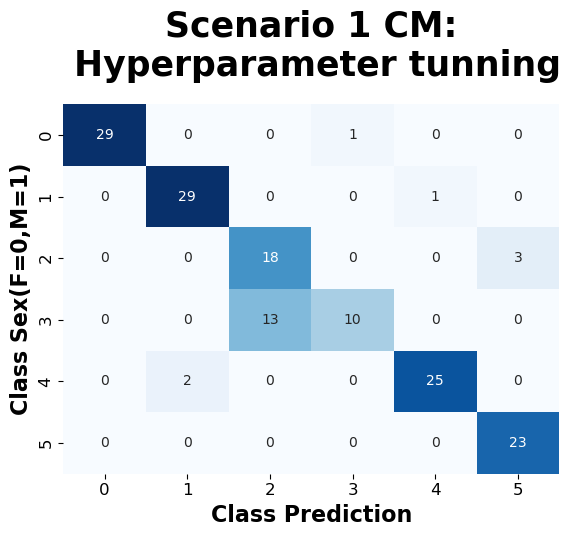

In [63]:
from sklearn.metrics import confusion_matrix

# confusion matrix
confusion_matrix(y_true=y_test, y_pred=y_pred)

# Generate the confusion matrix
confusion_matrix = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred)

# Create a heatmap of the confusion matrix

sns.heatmap(confusion_matrix, annot = True, fmt = "d", cmap = "Blues", cbar = False, )
plt.title('Scenario 1 CM:\n Hyperparameter tunning',loc="center", pad=20, fontsize=25, fontweight="bold")
plt.xlabel('Class Prediction',fontsize=16, fontweight='bold')
plt.ylabel('Class Sex(F=0,M=1)',fontsize=16, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Printing classification report
print(classification_report(y_test, y_pred))

# accuracy
print("accuracy", metrics.accuracy_score(y_test, y_pred))

svc = metrics.accuracy_score(y_test, y_pred)*100

# precision
print("precision", metrics.precision_score(y_test, y_pred, average='weighted'))

# recall/sensitivity
print("recall", metrics.recall_score(y_test, y_pred, average='weighted'))

## Grid Search to Find Optimal Hyperparameters

In [64]:
# creating a KFold object with 5 splits 
folds = KFold(n_splits = 5, shuffle = True, random_state = 0)

# specify range of hyperparameters
# Set the parameters by cross-validation
hyper_params = [ {'gamma': [0.01, 0.001, 0.0001],
                     'C': [1, 10, 100, 1000]}]#,
                


# specify model
model = SVC(kernel = "rbf")

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = model, 
                        param_grid = hyper_params, 
                        scoring = 'accuracy', 
                        cv = folds, 
                        verbose = 4, # Changing verbose from 1 to 4, to display records :)
                        return_train_score = True)      

# fit the model
model_cv.fit(X_train, y_train)     

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END C=1, gamma=0.01;, score=(train=0.487, test=0.366) total time=   0.0s
[CV 2/5] END C=1, gamma=0.01;, score=(train=0.356, test=0.252) total time=   0.0s
[CV 3/5] END C=1, gamma=0.01;, score=(train=0.340, test=0.333) total time=   0.0s
[CV 4/5] END C=1, gamma=0.01;, score=(train=0.354, test=0.260) total time=   0.0s
[CV 5/5] END C=1, gamma=0.01;, score=(train=0.346, test=0.295) total time=   0.0s
[CV 1/5] END C=1, gamma=0.001;, score=(train=0.187, test=0.122) total time=   0.0s
[CV 2/5] END C=1, gamma=0.001;, score=(train=0.356, test=0.252) total time=   0.0s
[CV 3/5] END C=1, gamma=0.001;, score=(train=0.177, test=0.171) total time=   0.0s
[CV 4/5] END C=1, gamma=0.001;, score=(train=0.181, test=0.146) total time=   0.0s
[CV 5/5] END C=1, gamma=0.001;, score=(train=0.183, test=0.123) total time=   0.0s
[CV 1/5] END C=1, gamma=0.0001;, score=(train=0.187, test=0.122) total time=   0.0s
[CV 2/5] END C=1, gamma=0.0001

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=SVC(),
             param_grid=[{'C': [1, 10, 100, 1000],
                          'gamma': [0.01, 0.001, 0.0001]}],
             return_train_score=True, scoring='accuracy', verbose=4)

In [65]:
## cv results
cv_results = pd.DataFrame(model_cv.cv_results_)

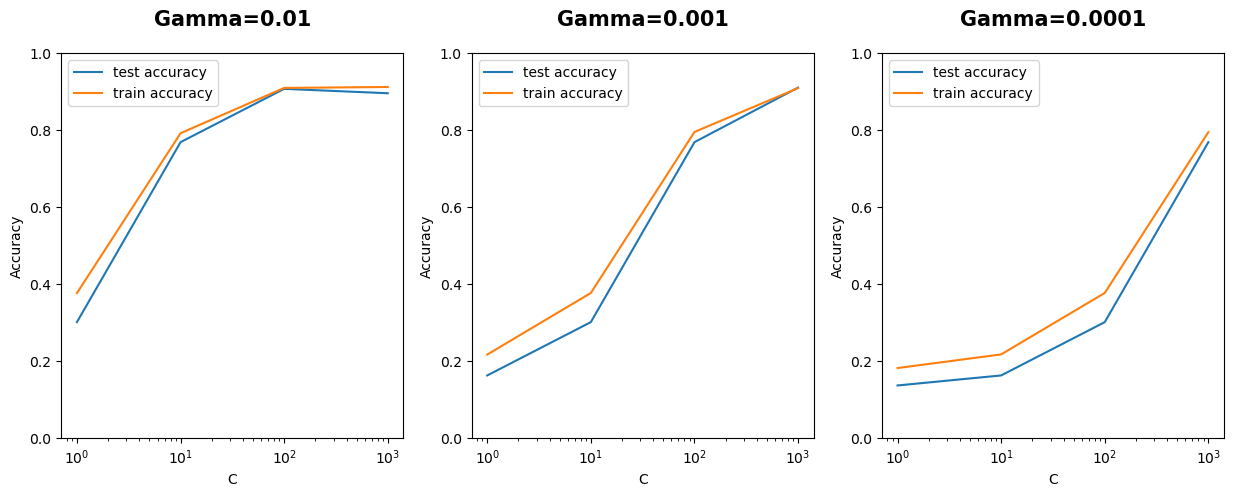

In [66]:
# converting C to numeric type for plotting on x-axis
cv_results['param_C'] = cv_results['param_C'].astype('int')

# # plotting
plt.figure(figsize=(15,5))

# subplot 1/3
plt.subplot(131)
gamma_01 = cv_results[cv_results['param_gamma']==0.01]

plt.plot(gamma_01["param_C"], gamma_01["mean_test_score"])
plt.plot(gamma_01["param_C"], gamma_01["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.01",fontweight="bold",loc="center", pad=20, fontsize=15)
plt.ylim([0, 1])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

# subplot 2/3
plt.subplot(132)
gamma_001 = cv_results[cv_results['param_gamma']==0.001]

plt.plot(gamma_001["param_C"], gamma_001["mean_test_score"])
plt.plot(gamma_001["param_C"], gamma_001["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.001",fontweight="bold",loc="center", pad=20, fontsize=15)
plt.ylim([0, 1])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')


# subplot 3/3
plt.subplot(133)
gamma_0001 = cv_results[cv_results['param_gamma']==0.0001]

plt.plot(gamma_0001["param_C"], gamma_0001["mean_test_score"])
plt.plot(gamma_0001["param_C"], gamma_0001["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.0001",fontweight="bold",loc="center", pad=20, fontsize=15)
plt.ylim([0, 1])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

In [67]:
# printing the optimal accuracy score and hyperparameters
best_score = model_cv.best_score_
best_hyperparams = model_cv.best_params_
print('Tree:',tree)
print('RF:',randomforest)
print('KNN:',KNN)
print('SVC:',svc)
print("The best test score is {0} corresponding to hyperparameters {1}".format(best_score, best_hyperparams))

Tree: 87.44588744588745
RF: 91.77489177489177
KNN: 87.44588744588745
SVC: 87.01298701298701
The best test score is 0.9104491536718646 corresponding to hyperparameters {'C': 1000, 'gamma': 0.001}


Gamma = 0.0001 is above 80% this by expanding the dataset the model is less overfitted, more fitted now!